100%|██████████████████████████████| 401/401 [00:00<00:00, 1587.70it/s]                                                               


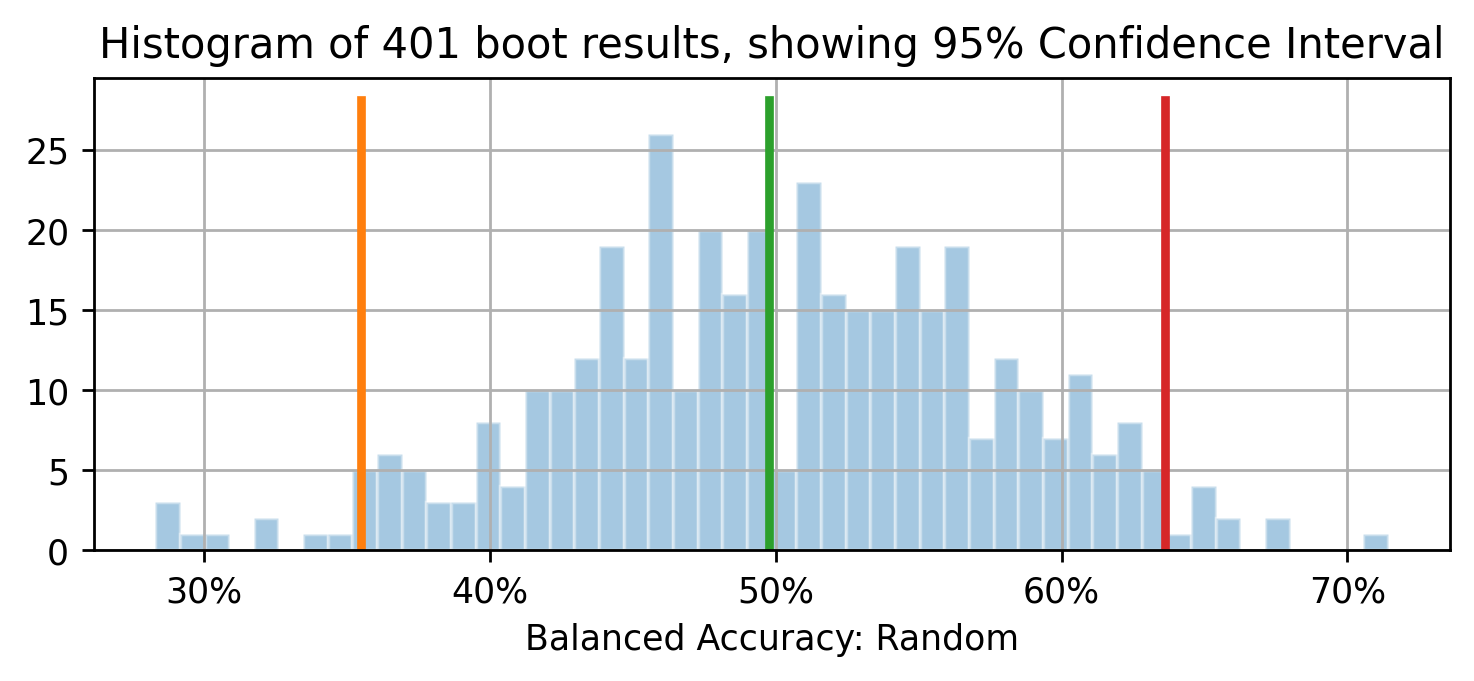

In [58]:
import re  # regular expressions
import numpy as np
import pandas as pd
from sklearn import metrics
from scipy import stats
import csv

def one_boot(*data_args):
    """Usage: (t, p) = one_boot(true, pred) with true, pred, t, p arrays of same length
    """
    length = len(data_args[0])
    #print(length)
    index = np.random.randint(0, length, size=length)  # apply same sampled index to all args:
    return [ pd.Series(arg.values[index], name=arg.name)  # .reset_index() is slower
             if isinstance(arg, pd.Series) else arg[index]   for  arg in data_args
           ]

golddata = pd.read_csv('/Users/xvirsh/shafqat/postDoc-Swe/project2022/LSCDBenchmark/usage-graph-data/dwug_en/stats/opt/stats_groupings.csv',delimiter='\t',quoting=csv.QUOTE_NONE)
golddata['lemma'] = golddata['lemma'].str.replace('_(\w+)','',regex=True)
gold_array = np.array(golddata['change_binary']) # for change binary


preddata = pd.read_csv('/Users/xvirsh/shafqat/postDoc-Swe/project2022/LSCDBenchmark/results/apd/scores_targets.tsv',delimiter='\t',quoting=csv.QUOTE_NONE) # for change_binary

preddata['lemma'] = preddata['lemma'].str.replace('_(\w+)','',regex=True)
pred_array = np.array(preddata['change_binary']) # for change_binary

(t,p) = one_boot(gold_array, pred_array)
#print(t,p)


def specificity_score(true, pred, **kwargs):
    """sklearn-compat Specificity metric func for binary: 1=posi class, 0=nega
    """
    return metrics.recall_score(1 - pd.Series(true), 1 - pd.Series(pred), **kwargs)

specificity_score.__name__ = "Specificity (Recall of −ve)"

def calc_metrics(metrics, *data_args):
    """Return a list of calculated values for each metric applied to *data_args
    where metrics is a metric func or iterable of funcs e.g. [m1, m2, m3, m4]
    """
    metrics=_fix_metrics(metrics)
    mname = metrics.__name__ if hasattr(metrics, '__name__') else "Metric"
    return pd.Series\
     ([m(*data_args) for m in metrics], index=[_metric_name(m) for m in metrics], name=mname)

def _metric_name(metric):  # use its prettified __name__
    name = re.sub(' score$', '', metric.__name__.replace('_',' ').strip())
    return name.title() if name.lower()==name else name

def _fix_metrics(metrics_): # allow for single metric func or any iterable of metric funcs
    if callable(metrics_): metrics_=[metrics_]  # single metric func to list of one
    return pd.Series(metrics_)  # in case iterable metrics_ is generator, generate & store

met=[ metrics.recall_score, specificity_score, 
      metrics.balanced_accuracy_score
    ]
calc_metrics(met, pred_array, gold_array)


import tqdm  # progress bar
def trange(iterable):  # narrower progress bar so it won't wrap
    return tqdm.trange(iterable, bar_format="{l_bar}{bar:30}{r_bar}{bar:-10b}")

def raw_metric_samples(metrics, *data_args, nboots):
    """Return dataframe containing metric(s) for nboots boot sample datasets
    where metrics is a metric func or iterable of funcs e.g. [m1, m2, m3]
    """
    metrics=_fix_metrics(metrics)
    cols=[ calc_metrics(metrics, *boot_data)   for boot_data  in _boot_generator\
           #(*data_args, nboots=nboots)  if boot_data[0].nunique() >1  # >1 for log Loss, ROC
          (*data_args, nboots=nboots)  # >1 for log Loss, ROC
         ]#end of list comprehension
    return pd.DataFrame\
      ( {iboot: col for iboot,col in enumerate(cols)}#end of dict comprehension
      ).rename_axis("Boot", axis="columns").rename_axis(cols[0].name)

def _boot_generator(*data_args, nboots): #return Gener of boot sampl datasets, not huge list!
    return (one_boot(*data_args) for _ in trange(nboots)) # generator expression

np.random.seed(13)

raw_metric_samples(met, pred_array, gold_array, 
          nboots=7).style.format('{:.2%}')  #optional #style


DFLT_ALPHA = 0.05     # MIN_BOOTS_IN_1TAIL includes tail boundary:
MIN_BOOTS_IN_1TAIL=11 # North et al.:10; Davidson&MacK ".05-->399"==>11, ".01-->1499"==>9
MAX_ALPHA = 0.40 # Make it .25 or .20?  Min boots formula dubious even at .40 or .25?

# Formula: boots_in_1tail = (nboots - 1) * (0.5*alpha) + 1 ; (0.5*alpha is size of 1 tail)
# E.g. nboots=6,alpha=0.40 (confid level =.60). With vals X[0] to X[5] sorted, quantiles are:
#   0.0 --> X[0]  (first of 2 in lower tail)
#   0.2 --> X[1]  interval lower  (0.5*alpha gives 0.2) (2nd of 2 in lower tail)
#   0.4 --> X[2]
#   0.6 --> X[3]
#   0.8 --> X[4]  interval upper  (1 - 0.5*alpha gives 0.8) (2nd of 2 in upper tail)
#   1.0 --> X[5]  (first of 2 in upper tail)
# so boots_in_1tail is (6-1)0.5*0.40+1 gives 2 per tail: X[0],X[1] in lowr, X[4],X[5] in uppr
def _min_nboots_from(alpha): # Calcul. using this formula (from abov), solved for min_nboots: 
                             # MIN_BOOTS_IN_1TAIL = (min_nboots - 1) * (0.5*alpha) + 1
    return int(np.ceil((MIN_BOOTS_IN_1TAIL - 1)/(0.5*alpha) + 1)) 
def _min_alpha_from(nboots): # Calc using this formula (frm above), but solved for min_alpha: 
                             # MIN_BOOTS_IN_1TAIL = (nboots - 1) * (0.5*min_alpha) + 1
    return 2 * (MIN_BOOTS_IN_1TAIL - 1) / (nboots - 1)
MIN_NBOOTS = _min_nboots_from(MAX_ALPHA)

def get_alpha_nboots(alpha=DFLT_ALPHA, nboots=None):
    """Return (alpha, nboots) with default nboots, applying MIN_NBOOTS & min alpha for nboots.
    """
    if alpha > MAX_ALPHA and (0 < (1-alpha) <= MAX_ALPHA):
        raise ValueError(f'alpha={alpha} > 0.5. Did you mean alpha={1-alpha:.9g}?')
    elif not (0 < alpha <= MAX_ALPHA):
        raise ValueError(f'alpha={alpha} is outside allowed range: 0 < alpha <= {MAX_ALPHA}')
    if pd.isna(nboots):   # by dflt use calculated min nboots for given alpha:
        nboots = _min_nboots_from(alpha)
    if int(nboots) != nboots: raise ValueError(f"nboots={nboots} isn't an integer")
    nboots = max(int(nboots), MIN_NBOOTS)  # apply min to a specified OR calculated nboots
    alpha = max(alpha, _min_alpha_from(nboots))  # apply min alpha for final nboots
    return (alpha, nboots)  # tuple of possibly-modified args

g = get_alpha_nboots 
pd.DataFrame( [ g(0.40), g(0.20, None), g(0.10), g(), g(alpha=0.02), 
                g(alpha=0.01, nboots=None), g(0.005, nboots=None)
              ], columns=['alpha', 'default nboots']
            ).set_index('alpha')

req=[(0.01,3000), (0.01,401), (0.01,2)]
out=[get_alpha_nboots(*args) for args in req]
mydf = lambda x: pd.DataFrame(x, columns=['alpha', 'nboots'])
pd.concat([mydf(req),mydf(out)],axis=1, keys=('Requested','Using'))


import matplotlib, matplotlib.ticker as mtick
def metric_boot_histogram(metric, *data_args, alpha=DFLT_ALPHA, nboots=None):
    """Plot histogram w/ lines for 1 observed metric & its confidence interval.
    """
    alpha, nboots = get_alpha_nboots(alpha, nboots) # 1-row df 2 series:
    #nboots = 40 #in case we want a hard coded nboots # shafqat
    series = raw_metric_samples(metric, *data_args, nboots=nboots).iloc[0,:]
    #print(series)
    nboots=len(series) # in case some failed
    (lo, hi) = series.quantile([0.5*alpha, 1 - 0.5*alpha])
    matplotlib.rcParams["figure.dpi"] = 250
    ax = series.hist(bins=50, figsize=(7, 2.5), alpha=0.4, edgecolor='white')
    showing = f", showing {100*(1-alpha):.4g}% Confidence Interval"
    ax.set_title(f"Histogram of {nboots} boot results" + showing)
    ax.set_xlabel(series.name+': Random')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    #print(metric(*data_args))
    for x in lo, metric(*data_args), hi:
        ax.plot([x, x], [0, nboots*.07], lw=2.5)
        
        
np.random.seed(13)
metric_boot_histogram\
(metrics.balanced_accuracy_score, pred_array, gold_array)
#(metrics.balanced_accuracy_score, pred_array, gold_array)


